Adapted by Rosa Zwart from Jupyter Notebooks found at https://github.com/PPerdomoQ/rare-disease-explainer

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle

import torch
from torch.utils.data import DataLoader

from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch
from deepsnap.graph import Graph

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gnn.linkpred_model import LinkPredModel, train, test
import data_params as input_data_params

In [2]:
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', torch_device)

Using device: cpu


# Set Parameters

Specify which dataset is used, 1 (original knowledge graph) or 2 (restructured knowledge graph)

In [3]:
dataset_prefix = input_data_params.dataset

disease_prefix = input_data_params.disease
assert disease_prefix == 'dmd' or 'hd' or 'oi'

embedding_method = 'e2v'

seeded_emb = input_data_params.e2v_seed

if seeded_emb:
    fixed_emb = '_seeded'
else:
    fixed_emb = ''

print(dataset_prefix, disease_prefix)

restr hd


# Set Folder

In [4]:
curr_working_dir = os.path.dirname(os.getcwd())
curr_output_dir = os.path.join(curr_working_dir, 'output', disease_prefix)
dataset_output_dir = os.path.join(curr_output_dir, f'{dataset_prefix}_{embedding_method}{fixed_emb}')

if not os.path.exists(dataset_output_dir):
    print('First, run the edge2vec embedding script. Then, run this script.')
else:
    print(f'Output folder for dataset {dataset_prefix} {disease_prefix} exists and will be used: {dataset_output_dir}')
    
run_folders_list = []
for item in os.listdir(dataset_output_dir):
    curr_path = os.path.join(dataset_output_dir, item)
    if os.path.isdir(curr_path) and 'run' in item:
        run_folders_list.append(item)
        
if len(run_folders_list) > 0:
    run_folders_list.sort(reverse=True)
    latest_run = run_folders_list[0]
    
    run_dir = os.path.join(dataset_output_dir, latest_run)
    
    pred_output_dir = os.path.join(run_dir, 'pred')
    if not os.path.exists(pred_output_dir):
        os.mkdir(pred_output_dir)
        print(f'Output folder for predictions from dataset {dataset_prefix} {disease_prefix} is created: {pred_output_dir}')
    else:
        print(f'Output folder for predictions from dataset {dataset_prefix} {disease_prefix} already exists and will be used: {pred_output_dir}')
    
else:
    print('First, run the edge2vec embedding script. Then, run this script.')

Output folder for dataset restr hd exists and will be used: C:\Users\rosa-\OneDrive\Documents\GitHub\XAI-FO\output\hd\restr_e2v
Output folder for predictions from dataset restr hd is created: C:\Users\rosa-\OneDrive\Documents\GitHub\XAI-FO\output\hd\restr_e2v\run_010\pred


In [5]:
run_dir

'C:\\Users\\rosa-\\OneDrive\\Documents\\GitHub\\XAI-FO\\output\\hd\\restr_e2v\\run_010'

# Load Data

Load all nodes

In [6]:
nodes = pd.read_csv(f'../output/{disease_prefix}/{dataset_prefix}_{disease_prefix}_indexed_nodes.csv')
nodes.drop('index_id', axis=1, inplace=True)
nodes['semantic'] = nodes['semantic'].astype('category')
nodes

,id,semantic,label,semantic_id
0,ENSEMBL:ENSSSCG00000033987,gene,UBE2E3,4
1,MP:0000790,phenotype,abnormal stratification in cerebral cortex,8
2,ZP:0011626,phenotype,"cell trunk apoptotic, abnormal",8
3,ZP:0019272,phenotype,pronephric nephron tubule epithelial cell diff...,8
4,ENSEMBL:ENSACAG00000007327,gene,ENSEMBL:ENSACAG00000007327,4
...,...,...,...,...
14877,MP:0008584,phenotype,photoreceptor outer segment degeneration,8
14878,ENSEMBL:ENSFCAG00000011716,gene,ENSEMBL:ENSFCAG00000011716,4
14879,MP:0009412,phenotype,skeletal muscle fiber degeneration,8
14880,ZP:0002448,phenotype,"retinal outer nuclear layer disorganized, abno...",8


In [7]:
if dataset_prefix == 'prev':
    drug_semantic_name = 'DRUG'
else:
    drug_semantic_name = 'drug'
    
nodes[nodes['semantic'] == drug_semantic_name]

,id,semantic,label,semantic_id
57,522,drug,carvedilol,3
190,5001,drug,eluxadoline,3
195,114,drug,alfentanil,3
283,2119,drug,phenazocine,3
512,5256,drug,copanlisib,3
...,...,...,...,...
14735,3157,drug,diosmin,3
14758,1805,drug,mifepristone,3
14785,1821,drug,mitoxantrone,3
14851,4118,drug,pazopanib,3


In [8]:
nodes.iloc[[24]]

,id,semantic,label,semantic_id
24,ZP:0000378,phenotype,"cardiac jelly increased volume, abnormal",8


The dictionary below can be used as mapping between generated semantic ID and semantic group label.

In [9]:
node_semantic_dict = dict(zip(nodes['semantic_id'], nodes['semantic']))
node_semantic_dict

{4: 'gene',
 8: 'phenotype',
 3: 'drug',
 7: 'molecular function',
 0: 'biological artifact',
 9: 'taxon',
 10: 'variant',
 6: 'genotype',
 5: 'gene product',
 1: 'biological process',
 2: 'disease'}

Load the node embeddings

In [10]:
def loadEdge2VecEmbedding(): 
    node_feat = KeyedVectors.load(f'{run_dir}/w2v_{dataset_prefix}_{disease_prefix}.dvectors', mmap='r')
    e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
    for idx, key in enumerate(node_feat.index_to_key):
        e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})
        
    return e2v_embedding.sort_values('Node')

In [11]:
embedding = loadEdge2VecEmbedding()
embedding

,Node,Embedding
0,0,"[0.13252565, -0.1611464, 0.008999971, 0.025334..."
1,1,"[0.13853446, -0.20387155, -0.006571308, 0.0561..."
2,2,"[0.13825284, -0.20753926, 0.0029043716, 0.0365..."
3,3,"[0.110843755, -0.13675536, -0.058031283, 0.038..."
4,4,"[0.058257855, -0.20879067, 0.08991305, 0.01281..."
...,...,...
14877,14877,"[0.0693241, -0.0881092, -0.015356085, 0.063320..."
14878,14878,"[0.15323506, -0.2183386, -0.02077197, 0.056754..."
14879,14879,"[0.12536395, -0.15534963, -0.022119183, 0.0664..."
14880,14880,"[0.21742862, -0.33455265, -0.10267707, -0.1389..."


Load the edges

In [12]:
edges = pd.read_csv(f'../output/{disease_prefix}/{dataset_prefix}_{disease_prefix}_indexed_edges.csv')
edges

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
0,HGNC:11280,SQSTM1,4,9467,interacts with,HGNC:9539,PSMB2,4,12355,0
1,FlyBase:FBgn0264855,AP-2alpha,4,6589,in orthology relationship with,MGI:101921,Ap2a1,4,10645,1
2,SGD:S000001709,VPS1,4,9926,in orthology relationship with,WormBase:WBGene00001134,eat-3,4,8881,1
3,RGD:1595923,RT1-A2,4,9824,in orthology relationship with,ENSEMBL:ENSDARG00000115781,CR339041.3,4,14166,1
4,WormBase:WBGene00012735,sptf-3,4,1165,in orthology relationship with,FlyBase:CG5669,FlyBase:CG5669,4,3446,1
...,...,...,...,...,...,...,...,...,...,...
230223,ENSEMBL:ENSGALG00000003800,PABPC4,4,942,in orthology relationship with,ENSEMBL:ENSECAG00000009396,ENSEMBL:ENSECAG00000009396,4,7423,1
230224,ENSEMBL:ENSECAG00000006095,ENSEMBL:ENSECAG00000006095,4,541,in orthology relationship with,ENSEMBL:ENSGALG00000050515,A0A3Q2UAA5,4,13107,1
230225,ZFIN:ZDB-GENE-060825-293,rab9a,4,4090,in orthology relationship with,ENSEMBL:ENSCAFG00000011750,ENSEMBL:ENSCAFG00000011750,4,3844,1
230226,ENSEMBL:ENSGALG00000008534,POLR2H,4,11884,in orthology relationship with,ZFIN:ZDB-GENE-050417-66,polr2h,4,3372,1


In [13]:
edges.loc[edges['index_tail'] == 2504]

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
48485,HGNC:144,ACTG1,4,6880,causes condition,HP:0002381,Aphasia,8,2504,2
54410,HGNC:30892,HUWE1,4,28,causes condition,HP:0002381,Aphasia,8,2504,2
94320,HGNC:6572,LGI1,4,5286,causes condition,HP:0002381,Aphasia,8,2504,2
151935,HGNC:12666,VCP,4,11564,causes condition,HP:0002381,Aphasia,8,2504,2
169169,HGNC:9069,PLEC,4,3519,causes condition,HP:0002381,Aphasia,8,2504,2
220573,HGNC:620,APP,4,10694,causes condition,HP:0002381,Aphasia,8,2504,2


Index list can be used later for converting back to the label of the relation.

In [14]:
_, relation_labels = pd.factorize(edges['relation'])
relation_labels

Index(['interacts with', 'in orthology relationship with', 'causes condition',
       'is variant in', 'enables', 'found in', 'contributes to condition',
       'colocalizes with', 'has role in modeling', 'expresses gene',
       'associated with phenotype', 'is of', 'targets',
       'is substance that treats', 'has affected feature', 'is product of',
       'is allele of', 'has genotype', 'involved in'],
      dtype='object')

# Link Prediction

In [15]:
gnn_params = {
    'dmd': {
        'prev': {
            'neg_sampl_ratio': 1.0,
            'device': torch_device,
            'hidden_dim': 256,
            'output_dim': 64,
            'epochs': 150,
            'lr': 0.07,
            'aggr': 'mean',
            'layers': 2,
            'dropout': 0.2
        }, 
        'restr': {
            'neg_sampl_ratio': 1.0,
            'device': torch_device,
            'hidden_dim': 256,
            'output_dim': 64,
            'epochs': 100,
            'lr': 0.013477408995651594,
            'aggr': 'mean',
            'layers': 2,
            'dropout': 0.2
        }
    },
    'hd': {
        'prev': {
            'neg_sampl_ratio': 1.5,
            'device': torch_device,
            'hidden_dim': 256,
            'output_dim': 64,
            'epochs': 150,
            'lr': 0.015119455370138871,
            'aggr': 'mean',
            'layers': 4,
            'dropout': 0.1
        }, 
        'restr': {
            'neg_sampl_ratio': 0.5,
            'device': torch_device,
            'hidden_dim': 256,
            'output_dim': 64,
            'epochs': 150,
            'lr': 0.036447056879784764,
            'aggr': 'sum',
            'layers': 6,
            'dropout': 0.2
        }
    },
    'oi': {
        'prev': {
            'neg_sampl_ratio': 1.5,
            'device': torch_device,
            'hidden_dim': 256,
            'output_dim': 64,
            'epochs': 100,
            'lr': 0.0006060400655270159,
            'aggr': 'mean',
            'layers': 2,
            'dropout': 0.2
        }, 
        'restr': {
            'neg_sampl_ratio': 1.0,
            'device': torch_device,
            'hidden_dim': 64,
            'output_dim': 128,
            'epochs': 150,
            'lr': 0.02678894881316133,
            'aggr': 'mean',
            'layers': 2,
            'dropout': 0.1
        }
    }
}

weight_decay = 5e-4
args = gnn_params[disease_prefix][dataset_prefix]

Creating a graph including the node embeddings as features of each node.

In [16]:
embedded_node_G = nx.Graph() # TODO: DiGraph() or Graph()?

for ind, node in embedding.iterrows(): 
  embedded_node_G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edges.iterrows(): 
  embedded_node_G.add_edge(int(edge['index_head']), int(edge['index_tail']))
    
for node in embedded_node_G.nodes(data=True):
    print(node)
    break
for edge in embedded_node_G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(embedded_node_G.number_of_edges()))
print("Number of nodes is {}".format(embedded_node_G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.1325, -0.1611,  0.0090,  0.0253,  0.0140,  0.1380, -0.2626, -0.1679,
        -0.0550,  0.1510,  0.0862, -0.0769,  0.0068, -0.0784, -0.0674,  0.0408,
        -0.1120,  0.0045,  0.2128, -0.0831,  0.1172, -0.0303, -0.0411, -0.0067,
         0.0862,  0.0329, -0.2598, -0.0087,  0.2121, -0.0187, -0.0023,  0.1453,
         0.0382, -0.0534,  0.0231, -0.1446, -0.1020,  0.1347,  0.0993,  0.0661,
         0.0407, -0.1220, -0.1159, -0.0981, -0.1817, -0.1948, -0.1019,  0.0925,
        -0.1083, -0.0243,  0.0913, -0.0011, -0.1560,  0.0113,  0.0617,  0.0831,
        -0.0857, -0.0811,  0.1383,  0.0789, -0.0918,  0.1685,  0.0116,  0.3780,
        -0.1061,  0.0796, -0.0321, -0.2743, -0.0580, -0.0428, -0.0373, -0.2968,
        -0.0794,  0.3384,  0.0475, -0.0402, -0.0728, -0.2009, -0.0099,  0.0597,
         0.0659,  0.0395,  0.1373,  0.0900,  0.0820, -0.0593,  0.1181,  0.1785,
         0.0510,  0.0777, -0.1465, -0.0264,  0.0215,  0.0578, -0.0084, -0.1424,
        -0.0605,  0

## Generate graph datasets for training, validation and testing

Transductive link prediction split (https://zqfang.github.io/2021-08-12-graph-linkpredict/):
- Train/validation/test sets are on the same graph
- The dataset consists of one graph
- The entire graph can be observed in all dataset splits
- The labels of the edges are split

In [17]:
dataset = GraphDataset(
    embedded_node_G,
    task='link_pred',
    edge_train_mode='all',
    edge_negative_sampling_ratio=args['neg_sampl_ratio']
)

datasets = {}
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1]
)

input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

print(f'Input dimension (embedding dimension): {input_dim} \n Number of edge classes (link or no link): {num_classes}')   

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Input dimension (embedding dimension): 128 
 Number of edge classes (link or no link): 2


Dataloaders allow to feed data into the model by batch.

In [18]:
dataloaders = {split: DataLoader(ds, collate_fn=Batch.collate([]), batch_size=1, shuffle=(split=='train')) for split, ds in datasets.items()}

## Train GNN

### Predefined Arguments

Train GNN with predefined arguments

In [19]:
print(args, weight_decay)

model = LinkPredModel(input_dim, args['hidden_dim'], args['output_dim'], args['layers'], args['aggr'], args['dropout'], args['device']).to(args['device'])
optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9, weight_decay=weight_decay)

{'neg_sampl_ratio': 0.5, 'device': device(type='cpu'), 'hidden_dim': 256, 'output_dim': 64, 'epochs': 150, 'lr': 0.036447056879784764, 'aggr': 'sum', 'layers': 6, 'dropout': 0.2} 0.0005


In [20]:
best_model, best_x, performance = train(model, dataloaders, optimizer, args)

best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)

print('Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(best_train_roc, best_val_roc, best_test_roc))

Start Train Function
Epoch: 001, Train: 0.8536, Val: 0.8346, Test: 0.8406, Loss: 1.58343


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 002, Train: 0.8421, Val: 0.8220, Test: 0.8265, Loss: 1.50295


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 003, Train: 0.8420, Val: 0.8220, Test: 0.8259, Loss: 1.47615


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 004, Train: 0.8463, Val: 0.8267, Test: 0.8304, Loss: 1.36991


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 005, Train: 0.8552, Val: 0.8337, Test: 0.8378, Loss: 1.29717


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 006, Train: 0.8576, Val: 0.8349, Test: 0.8393, Loss: 1.25188


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 007, Train: 0.8569, Val: 0.8344, Test: 0.8389, Loss: 1.18511


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 008, Train: 0.8611, Val: 0.8369, Test: 0.8417, Loss: 1.12369


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 009, Train: 0.8659, Val: 0.8412, Test: 0.8460, Loss: 1.08091


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 010, Train: 0.8704, Val: 0.8456, Test: 0.8493, Loss: 1.04227


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 011, Train: 0.8746, Val: 0.8501, Test: 0.8526, Loss: 0.99779


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 012, Train: 0.8801, Val: 0.8546, Test: 0.8558, Loss: 0.95389


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 013, Train: 0.8851, Val: 0.8582, Test: 0.8587, Loss: 0.90286


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 014, Train: 0.8902, Val: 0.8615, Test: 0.8619, Loss: 0.86255


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 015, Train: 0.8931, Val: 0.8637, Test: 0.8640, Loss: 0.81159


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 016, Train: 0.8962, Val: 0.8651, Test: 0.8655, Loss: 0.78298


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 017, Train: 0.8981, Val: 0.8668, Test: 0.8672, Loss: 0.76066


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 018, Train: 0.9030, Val: 0.8712, Test: 0.8715, Loss: 0.71909


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 019, Train: 0.9079, Val: 0.8773, Test: 0.8777, Loss: 0.70104


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 020, Train: 0.9168, Val: 0.8837, Test: 0.8847, Loss: 0.67506


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 021, Train: 0.9214, Val: 0.8891, Test: 0.8905, Loss: 0.65569


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 022, Train: 0.9268, Val: 0.8934, Test: 0.8950, Loss: 0.61638


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 023, Train: 0.9305, Val: 0.8972, Test: 0.8987, Loss: 0.61963


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 024, Train: 0.9346, Val: 0.9005, Test: 0.9017, Loss: 0.58538


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 025, Train: 0.9359, Val: 0.9023, Test: 0.9031, Loss: 0.57539


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 026, Train: 0.9382, Val: 0.9039, Test: 0.9045, Loss: 0.54939


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 027, Train: 0.9408, Val: 0.9058, Test: 0.9064, Loss: 0.53985


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 028, Train: 0.9430, Val: 0.9076, Test: 0.9083, Loss: 0.53626


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 029, Train: 0.9456, Val: 0.9101, Test: 0.9109, Loss: 0.51653


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 030, Train: 0.9467, Val: 0.9121, Test: 0.9133, Loss: 0.49661


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 031, Train: 0.9494, Val: 0.9140, Test: 0.9156, Loss: 0.48239


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 032, Train: 0.9509, Val: 0.9163, Test: 0.9181, Loss: 0.47813


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 033, Train: 0.9533, Val: 0.9183, Test: 0.9203, Loss: 0.47391


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 034, Train: 0.9558, Val: 0.9201, Test: 0.9223, Loss: 0.47002


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 035, Train: 0.9574, Val: 0.9215, Test: 0.9238, Loss: 0.47979


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 036, Train: 0.9583, Val: 0.9229, Test: 0.9254, Loss: 0.44244


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 037, Train: 0.9597, Val: 0.9235, Test: 0.9262, Loss: 0.44723


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 038, Train: 0.9600, Val: 0.9240, Test: 0.9274, Loss: 0.43247


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 039, Train: 0.9612, Val: 0.9255, Test: 0.9286, Loss: 0.44692


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 040, Train: 0.9617, Val: 0.9266, Test: 0.9296, Loss: 0.43272


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 041, Train: 0.9630, Val: 0.9283, Test: 0.9311, Loss: 0.43145


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 042, Train: 0.9647, Val: 0.9300, Test: 0.9328, Loss: 0.41231


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 043, Train: 0.9668, Val: 0.9314, Test: 0.9343, Loss: 0.41001


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 044, Train: 0.9679, Val: 0.9323, Test: 0.9354, Loss: 0.41037


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 045, Train: 0.9688, Val: 0.9331, Test: 0.9362, Loss: 0.41473


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 046, Train: 0.9699, Val: 0.9338, Test: 0.9369, Loss: 0.40058


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 047, Train: 0.9700, Val: 0.9345, Test: 0.9377, Loss: 0.40929


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 048, Train: 0.9699, Val: 0.9355, Test: 0.9386, Loss: 0.40059


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 049, Train: 0.9701, Val: 0.9363, Test: 0.9394, Loss: 0.40306


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 050, Train: 0.9707, Val: 0.9366, Test: 0.9400, Loss: 0.39557


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 051, Train: 0.9715, Val: 0.9378, Test: 0.9412, Loss: 0.41070


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 052, Train: 0.9720, Val: 0.9402, Test: 0.9432, Loss: 0.39927


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 053, Train: 0.9728, Val: 0.9445, Test: 0.9477, Loss: 0.38383


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 054, Train: 0.9740, Val: 0.9483, Test: 0.9514, Loss: 0.39193


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 055, Train: 0.9749, Val: 0.9498, Test: 0.9528, Loss: 0.39319


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 056, Train: 0.9761, Val: 0.9502, Test: 0.9529, Loss: 0.38274


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 057, Train: 0.9767, Val: 0.9487, Test: 0.9511, Loss: 0.39049


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 058, Train: 0.9768, Val: 0.9483, Test: 0.9507, Loss: 0.37941


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 059, Train: 0.9769, Val: 0.9488, Test: 0.9516, Loss: 0.37470


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 060, Train: 0.9774, Val: 0.9491, Test: 0.9524, Loss: 0.37656


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 061, Train: 0.9773, Val: 0.9499, Test: 0.9537, Loss: 0.37929


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 062, Train: 0.9777, Val: 0.9518, Test: 0.9556, Loss: 0.37538


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 063, Train: 0.9775, Val: 0.9537, Test: 0.9573, Loss: 0.37429


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 064, Train: 0.9787, Val: 0.9545, Test: 0.9582, Loss: 0.36851


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 065, Train: 0.9783, Val: 0.9552, Test: 0.9591, Loss: 0.37448


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 066, Train: 0.9791, Val: 0.9549, Test: 0.9588, Loss: 0.37535


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 067, Train: 0.9789, Val: 0.9548, Test: 0.9586, Loss: 0.37283


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 068, Train: 0.9791, Val: 0.9558, Test: 0.9593, Loss: 0.37027


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 069, Train: 0.9792, Val: 0.9577, Test: 0.9615, Loss: 0.37524


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 070, Train: 0.9799, Val: 0.9589, Test: 0.9631, Loss: 0.36743


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 071, Train: 0.9799, Val: 0.9589, Test: 0.9632, Loss: 0.36454


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 072, Train: 0.9809, Val: 0.9591, Test: 0.9634, Loss: 0.37271


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 073, Train: 0.9812, Val: 0.9584, Test: 0.9626, Loss: 0.35798


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 074, Train: 0.9814, Val: 0.9570, Test: 0.9609, Loss: 0.35873


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 075, Train: 0.9815, Val: 0.9556, Test: 0.9593, Loss: 0.36145


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 076, Train: 0.9811, Val: 0.9548, Test: 0.9589, Loss: 0.36045


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 077, Train: 0.9813, Val: 0.9548, Test: 0.9589, Loss: 0.36570


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 078, Train: 0.9811, Val: 0.9555, Test: 0.9598, Loss: 0.35687


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 079, Train: 0.9811, Val: 0.9573, Test: 0.9622, Loss: 0.35415


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 080, Train: 0.9806, Val: 0.9600, Test: 0.9650, Loss: 0.35044


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 081, Train: 0.9806, Val: 0.9618, Test: 0.9666, Loss: 0.36169


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 082, Train: 0.9814, Val: 0.9630, Test: 0.9677, Loss: 0.35647


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 083, Train: 0.9810, Val: 0.9638, Test: 0.9685, Loss: 0.35314


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 084, Train: 0.9812, Val: 0.9637, Test: 0.9683, Loss: 0.36060


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 085, Train: 0.9815, Val: 0.9633, Test: 0.9679, Loss: 0.35804


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 086, Train: 0.9813, Val: 0.9634, Test: 0.9681, Loss: 0.35861


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 087, Train: 0.9813, Val: 0.9643, Test: 0.9690, Loss: 0.35868


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 088, Train: 0.9811, Val: 0.9651, Test: 0.9699, Loss: 0.34523


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 089, Train: 0.9810, Val: 0.9659, Test: 0.9710, Loss: 0.34536


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 090, Train: 0.9810, Val: 0.9659, Test: 0.9714, Loss: 0.34396


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 091, Train: 0.9806, Val: 0.9651, Test: 0.9711, Loss: 0.34942


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 092, Train: 0.9797, Val: 0.9640, Test: 0.9705, Loss: 0.35119


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 093, Train: 0.9805, Val: 0.9635, Test: 0.9704, Loss: 0.34401


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 094, Train: 0.9803, Val: 0.9639, Test: 0.9706, Loss: 0.34064


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 095, Train: 0.9806, Val: 0.9646, Test: 0.9709, Loss: 0.34443


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 096, Train: 0.9802, Val: 0.9654, Test: 0.9712, Loss: 0.34787


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 097, Train: 0.9804, Val: 0.9656, Test: 0.9711, Loss: 0.33736


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 098, Train: 0.9808, Val: 0.9656, Test: 0.9708, Loss: 0.34741


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 099, Train: 0.9804, Val: 0.9655, Test: 0.9706, Loss: 0.34371


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 100, Train: 0.9805, Val: 0.9655, Test: 0.9706, Loss: 0.33435


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 101, Train: 0.9802, Val: 0.9654, Test: 0.9706, Loss: 0.34257


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 102, Train: 0.9811, Val: 0.9655, Test: 0.9705, Loss: 0.34637


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 103, Train: 0.9812, Val: 0.9654, Test: 0.9702, Loss: 0.35103


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 104, Train: 0.9815, Val: 0.9654, Test: 0.9701, Loss: 0.33165


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 105, Train: 0.9822, Val: 0.9657, Test: 0.9705, Loss: 0.34564


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 106, Train: 0.9816, Val: 0.9660, Test: 0.9708, Loss: 0.34117


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 107, Train: 0.9817, Val: 0.9664, Test: 0.9713, Loss: 0.33625


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 108, Train: 0.9814, Val: 0.9666, Test: 0.9717, Loss: 0.34357


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 109, Train: 0.9816, Val: 0.9666, Test: 0.9720, Loss: 0.33135


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 110, Train: 0.9812, Val: 0.9666, Test: 0.9722, Loss: 0.34303


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 111, Train: 0.9817, Val: 0.9664, Test: 0.9720, Loss: 0.33563


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 112, Train: 0.9822, Val: 0.9663, Test: 0.9719, Loss: 0.33490


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 113, Train: 0.9822, Val: 0.9659, Test: 0.9713, Loss: 0.33254


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 114, Train: 0.9829, Val: 0.9660, Test: 0.9710, Loss: 0.33399


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 115, Train: 0.9834, Val: 0.9662, Test: 0.9709, Loss: 0.34095


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 116, Train: 0.9830, Val: 0.9666, Test: 0.9712, Loss: 0.34090


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 117, Train: 0.9833, Val: 0.9667, Test: 0.9713, Loss: 0.33303


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 118, Train: 0.9838, Val: 0.9665, Test: 0.9710, Loss: 0.32788


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 119, Train: 0.9831, Val: 0.9664, Test: 0.9708, Loss: 0.33028


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 120, Train: 0.9833, Val: 0.9664, Test: 0.9707, Loss: 0.33393


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 121, Train: 0.9831, Val: 0.9665, Test: 0.9706, Loss: 0.33544


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 122, Train: 0.9835, Val: 0.9667, Test: 0.9707, Loss: 0.33372


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 123, Train: 0.9840, Val: 0.9668, Test: 0.9706, Loss: 0.32194


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 124, Train: 0.9841, Val: 0.9663, Test: 0.9700, Loss: 0.32655


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 125, Train: 0.9842, Val: 0.9651, Test: 0.9689, Loss: 0.31937


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 126, Train: 0.9842, Val: 0.9636, Test: 0.9676, Loss: 0.32519


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 127, Train: 0.9845, Val: 0.9620, Test: 0.9661, Loss: 0.32346


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 128, Train: 0.9841, Val: 0.9609, Test: 0.9651, Loss: 0.32212


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 129, Train: 0.9843, Val: 0.9601, Test: 0.9644, Loss: 0.32743


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 130, Train: 0.9843, Val: 0.9602, Test: 0.9645, Loss: 0.33240


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 131, Train: 0.9846, Val: 0.9603, Test: 0.9646, Loss: 0.32926


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 132, Train: 0.9848, Val: 0.9604, Test: 0.9647, Loss: 0.32139


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 133, Train: 0.9843, Val: 0.9607, Test: 0.9649, Loss: 0.32466


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 134, Train: 0.9844, Val: 0.9614, Test: 0.9656, Loss: 0.32538


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 135, Train: 0.9845, Val: 0.9628, Test: 0.9668, Loss: 0.32328


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 136, Train: 0.9845, Val: 0.9637, Test: 0.9677, Loss: 0.32773


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 137, Train: 0.9845, Val: 0.9636, Test: 0.9675, Loss: 0.32684


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 138, Train: 0.9846, Val: 0.9636, Test: 0.9674, Loss: 0.32614


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 139, Train: 0.9845, Val: 0.9636, Test: 0.9675, Loss: 0.31786


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 140, Train: 0.9846, Val: 0.9636, Test: 0.9675, Loss: 0.32636


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 141, Train: 0.9849, Val: 0.9639, Test: 0.9678, Loss: 0.32573


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 142, Train: 0.9843, Val: 0.9632, Test: 0.9671, Loss: 0.32252


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 143, Train: 0.9849, Val: 0.9624, Test: 0.9662, Loss: 0.32155


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 144, Train: 0.9853, Val: 0.9615, Test: 0.9652, Loss: 0.31642


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 145, Train: 0.9854, Val: 0.9614, Test: 0.9652, Loss: 0.32321


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 146, Train: 0.9854, Val: 0.9617, Test: 0.9655, Loss: 0.32655


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 147, Train: 0.9852, Val: 0.9615, Test: 0.9652, Loss: 0.31279


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 148, Train: 0.9859, Val: 0.9612, Test: 0.9649, Loss: 0.32036


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 149, Train: 0.9857, Val: 0.9609, Test: 0.9646, Loss: 0.32168


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Train: 0.9837, Val: 0.9668, Test: 0.9706


Save the model and parameters

In [21]:
torch.save(best_model.state_dict(), f'{run_dir}/{dataset_prefix}_{disease_prefix}_best_model_{embedding_method}.pth')
with open(f'{run_dir}/{dataset_prefix}_{disease_prefix}_best_model_{embedding_method}_args.pkl', 'wb') as f:
    pickle.dump(args, f)

### Visualize Trained GNN Model Accuracy

Plot AUC and loss throughout epochs

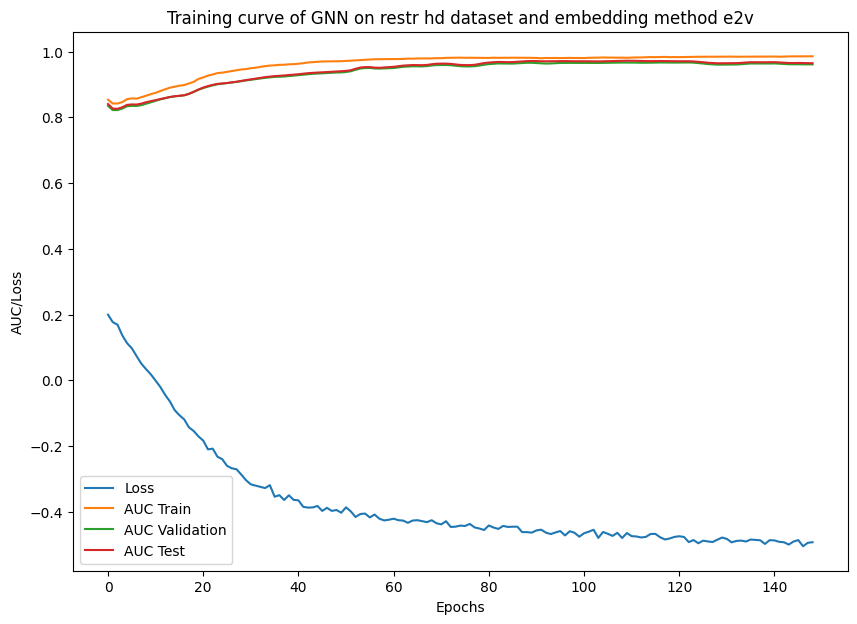

In [22]:
plt.figure(figsize= (10,7))
plt.plot(np.log10(performance[0]), label = 'Loss')
plt.plot(performance[1], label = 'AUC Train')
plt.plot(performance[2], label = 'AUC Validation')
plt.plot(performance[3], label = 'AUC Test')
plt.legend()
plt.ylabel('AUC/Loss')
plt.xlabel('Epochs')
plt.title(f'Training curve of GNN on {dataset_prefix} {disease_prefix} dataset and embedding method {embedding_method}')
plt.show()

In [23]:
performance_scores = {}
sets = ['Loss', 'AUC Train', 'AUC Validation', 'AUC Test']
for set_name, score_list in zip(sets, performance):
    performance_scores[set_name] = score_list

Plot ROC curve using test set
- High TPR and lower FPR indicates that the proportion of correctly classified samples (true positives) is greater than the proportion of incorrectly classified samples (false positives)

ROC AUC score: 0.9705860131920414


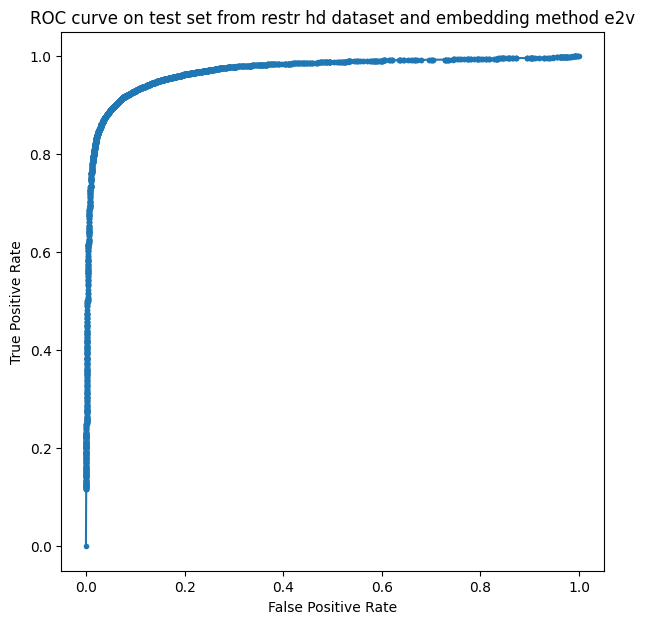

In [24]:
for batch in dataloaders['test']:
    feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
    batch.to(args["device"])
    pred, x = best_model(feat, edge_index, edge_label_index, training = False)
    pred = torch.sigmoid(pred)
    score = roc_auc_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    
    performance_scores['ROC AUC Score'] = score
    print(f'ROC AUC score: {score}')
    
fpr, tpr, thresholds = roc_curve(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
performance_scores['ROC FPR'] = fpr
performance_scores['ROC TPR'] = tpr
performance_scores['ROC Thresholds'] = thresholds

plt.figure(figsize = (7, 7))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')   # 1 - specificity
plt.ylabel('True Positive Rate')    # sensitivity
plt.title(f'ROC curve on test set from {dataset_prefix} {disease_prefix} dataset and embedding method {embedding_method}')
plt.show()

Calculate F1-score using test set

Elements of the F1-score:
- Precision represents the proportion of correctly classifying samples as positive (high precision: classifying a sample as positive has a high probability to be correct)
- Recall represents the proportion of finding all positives (high recall: all positive samples have been classified as being positive)

Maximizing both elements in order to yield a model that identifies all positive samples and only identifies these samples as positives.

For the F1-score, the average of precision and recall is calculated, using the harmonic mean method (equal importance):
- High F1-score indicates that precision and recall are both high
- Medium F1-score indicates that one of the elements is high and the other low
- Low F1-score indicates that precision and recall are both low

In [25]:
def test_f1(model, dataloader, args, threshold):
    model.eval()
    score = 0
    num_batches = 0
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred) > threshold
        score += f1_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
        num_batches += 1
    score /= num_batches 
    return batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy(), score

true_label, pred_label, best_test_f1 = test_f1(best_model, dataloaders['test'], args, 0.7)
performance_scores['True Labels'] = true_label
performance_scores['Predicted Labels'] = pred_label
performance_scores['F1 Score'] = best_test_f1

print(f'F1-Score in the test set from {dataset_prefix} {disease_prefix} dataset and embedding method {embedding_method}:', best_test_f1)
print(classification_report(true_label, pred_label))

F1-Score in the test set from restr hd dataset and embedding method e2v: 0.9382850504610469
              precision    recall  f1-score   support

           0       0.90      0.85      0.87     13600
           1       0.93      0.95      0.94     27200

    accuracy                           0.92     40800
   macro avg       0.91      0.90      0.91     40800
weighted avg       0.92      0.92      0.92     40800



In [26]:
performance_scores

{'Loss': [array(1.5834289, dtype=float32),
  array(1.5029471, dtype=float32),
  array(1.4761482, dtype=float32),
  array(1.3699104, dtype=float32),
  array(1.2971721, dtype=float32),
  array(1.2518809, dtype=float32),
  array(1.1851084, dtype=float32),
  array(1.1236895, dtype=float32),
  array(1.0809064, dtype=float32),
  array(1.042266, dtype=float32),
  array(0.99779236, dtype=float32),
  array(0.95389074, dtype=float32),
  array(0.9028615, dtype=float32),
  array(0.86255026, dtype=float32),
  array(0.81159145, dtype=float32),
  array(0.78297514, dtype=float32),
  array(0.7606619, dtype=float32),
  array(0.7190895, dtype=float32),
  array(0.7010395, dtype=float32),
  array(0.6750578, dtype=float32),
  array(0.6556902, dtype=float32),
  array(0.61637944, dtype=float32),
  array(0.61962885, dtype=float32),
  array(0.58538437, dtype=float32),
  array(0.5753947, dtype=float32),
  array(0.5493861, dtype=float32),
  array(0.53984606, dtype=float32),
  array(0.53626174, dtype=float32),
  a

In [27]:
def test_cm(model, dataloader, args, threshold):
    model.eval()
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred) > threshold
        score = confusion_matrix(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    return score

table = test_cm(best_model, dataloaders['test'], args, 0.8)
table

array([[12613,   987],
       [ 2364, 24836]], dtype=int64)

In [28]:
performance_scores

{'Loss': [array(1.5834289, dtype=float32),
  array(1.5029471, dtype=float32),
  array(1.4761482, dtype=float32),
  array(1.3699104, dtype=float32),
  array(1.2971721, dtype=float32),
  array(1.2518809, dtype=float32),
  array(1.1851084, dtype=float32),
  array(1.1236895, dtype=float32),
  array(1.0809064, dtype=float32),
  array(1.042266, dtype=float32),
  array(0.99779236, dtype=float32),
  array(0.95389074, dtype=float32),
  array(0.9028615, dtype=float32),
  array(0.86255026, dtype=float32),
  array(0.81159145, dtype=float32),
  array(0.78297514, dtype=float32),
  array(0.7606619, dtype=float32),
  array(0.7190895, dtype=float32),
  array(0.7010395, dtype=float32),
  array(0.6750578, dtype=float32),
  array(0.6556902, dtype=float32),
  array(0.61637944, dtype=float32),
  array(0.61962885, dtype=float32),
  array(0.58538437, dtype=float32),
  array(0.5753947, dtype=float32),
  array(0.5493861, dtype=float32),
  array(0.53984606, dtype=float32),
  array(0.53626174, dtype=float32),
  a

In [29]:
with open(f'{pred_output_dir}/{dataset_prefix}_{disease_prefix}_performance_scores_{embedding_method}.pkl', 'wb') as f:
    pickle.dump(performance_scores, f)

# Hyperparameter Optimization of Node Embedding and GNN Training

The routine including node embedding and GNN training that needs to be optimized is contained in `hyperparam_opt.py`.

# GNN Predictions

Load the Edge2Vec embedding

In [30]:
embedding

,Node,Embedding
0,0,"[0.13252565, -0.1611464, 0.008999971, 0.025334..."
1,1,"[0.13853446, -0.20387155, -0.006571308, 0.0561..."
2,2,"[0.13825284, -0.20753926, 0.0029043716, 0.0365..."
3,3,"[0.110843755, -0.13675536, -0.058031283, 0.038..."
4,4,"[0.058257855, -0.20879067, 0.08991305, 0.01281..."
...,...,...
14877,14877,"[0.0693241, -0.0881092, -0.015356085, 0.063320..."
14878,14878,"[0.15323506, -0.2183386, -0.02077197, 0.056754..."
14879,14879,"[0.12536395, -0.15534963, -0.022119183, 0.0664..."
14880,14880,"[0.21742862, -0.33455265, -0.10267707, -0.1389..."


Initialize a graph with nodes and their embedding features.

In [31]:
for node in embedded_node_G.nodes(data=True):
    print(node)
    break
for edge in embedded_node_G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(embedded_node_G.number_of_edges()))
print("Number of nodes is {}".format(embedded_node_G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.1325, -0.1611,  0.0090,  0.0253,  0.0140,  0.1380, -0.2626, -0.1679,
        -0.0550,  0.1510,  0.0862, -0.0769,  0.0068, -0.0784, -0.0674,  0.0408,
        -0.1120,  0.0045,  0.2128, -0.0831,  0.1172, -0.0303, -0.0411, -0.0067,
         0.0862,  0.0329, -0.2598, -0.0087,  0.2121, -0.0187, -0.0023,  0.1453,
         0.0382, -0.0534,  0.0231, -0.1446, -0.1020,  0.1347,  0.0993,  0.0661,
         0.0407, -0.1220, -0.1159, -0.0981, -0.1817, -0.1948, -0.1019,  0.0925,
        -0.1083, -0.0243,  0.0913, -0.0011, -0.1560,  0.0113,  0.0617,  0.0831,
        -0.0857, -0.0811,  0.1383,  0.0789, -0.0918,  0.1685,  0.0116,  0.3780,
        -0.1061,  0.0796, -0.0321, -0.2743, -0.0580, -0.0428, -0.0373, -0.2968,
        -0.0794,  0.3384,  0.0475, -0.0402, -0.0728, -0.2009, -0.0099,  0.0597,
         0.0659,  0.0395,  0.1373,  0.0900,  0.0820, -0.0593,  0.1181,  0.1785,
         0.0510,  0.0777, -0.1465, -0.0264,  0.0215,  0.0578, -0.0084, -0.1424,
        -0.0605,  0

In [32]:
DeepG = Graph(embedded_node_G)
print(DeepG.edge_index.shape)

torch.Size([2, 271976])


Load arguments and parameters of trained GNN model.

In [33]:
with open(f'{run_dir}/{dataset_prefix}_{disease_prefix}_best_model_{embedding_method}_args.pkl', 'rb') as f:
    loaded_args = pickle.load(f)
    
best_model = LinkPredModel(len(embedding['Embedding'][0]), loaded_args['hidden_dim'], loaded_args['output_dim'], loaded_args['layers'], loaded_args['aggr'], loaded_args['dropout'], loaded_args['device']).to(loaded_args['device'])
best_model.load_state_dict(torch.load(f'{run_dir}/{dataset_prefix}_{disease_prefix}_best_model_{embedding_method}.pth'))

<All keys matched successfully>

Get output of best model given the graph

In [34]:
_, best_x = best_model(DeepG.node_feature, DeepG.edge_index, DeepG.edge_label_index, training = False)
print(best_x.shape)

torch.Size([14882, 64])


In [35]:
nodes

,id,semantic,label,semantic_id
0,ENSEMBL:ENSSSCG00000033987,gene,UBE2E3,4
1,MP:0000790,phenotype,abnormal stratification in cerebral cortex,8
2,ZP:0011626,phenotype,"cell trunk apoptotic, abnormal",8
3,ZP:0019272,phenotype,pronephric nephron tubule epithelial cell diff...,8
4,ENSEMBL:ENSACAG00000007327,gene,ENSEMBL:ENSACAG00000007327,4
...,...,...,...,...
14877,MP:0008584,phenotype,photoreceptor outer segment degeneration,8
14878,ENSEMBL:ENSFCAG00000011716,gene,ENSEMBL:ENSFCAG00000011716,4
14879,MP:0009412,phenotype,skeletal muscle fiber degeneration,8
14880,ZP:0002448,phenotype,"retinal outer nuclear layer disorganized, abno...",8


Define the score function

In [36]:
def score(x, id1, id2): 
    n1 = x[id1]
    n2 = x[id2]
    
    score = torch.Tensor([torch.sum(n1 * n2, dim=-1)])
    p = torch.sigmoid(score).cpu().detach().numpy()
    return p

def candidates(nodes, id, x): 
  ind = nodes[nodes['id'] == id].index.values.astype(int)[0]
  predictions = nodes.copy()
  scores = []
  for i in range(len(x)):  
    s = score(x, i, ind)
    scores.append(s)
    
  predictions['Score'] = scores
  return predictions

Calculate the predictions of an edge existing or not between given node ID and each node in the graph contained by semantic group DRUG. Show the top 20 highest probability that an edge exists between a pair of nodes.

In [37]:
if dataset_prefix == 'prev':
    drug_semantic = 'DRUG'
else:
    drug_semantic = 'drug'

predictions = candidates(nodes, 'HP:0001265', best_x)

predictions[predictions['semantic'] == drug_semantic].sort_values(by = ['Score'], ascending = False).head(20)

,id,semantic,label,semantic_id,Score
14873,91,drug,adenosine triphosphate,3,[0.99487716]
6091,5359,drug,brilliant Blue G,3,[0.9748799]
13124,2286,drug,promethazine,3,[0.97240067]
12146,434,drug,buprenorphine,3,[0.9611151]
6757,1990,drug,omeprazole,3,[0.9502845]
6316,2054,drug,pantoprazole,3,[0.95015806]
7127,918,drug,diphenoxylate,3,[0.9293429]
6730,1599,drug,loperamide,3,[0.91934997]
12144,2817,drug,vesnarinone,3,[0.91499555]
9303,1364,drug,hexachlorophene,3,[0.9095013]


Use the node semantics dictionary

In [38]:
node_semantics = nodes[['semantic', 'semantic_id']].drop_duplicates().set_index('semantic_id').to_dict()
node_semantics_dict = node_semantics['semantic']

node_semantics_dict

{4: 'gene',
 8: 'phenotype',
 3: 'drug',
 7: 'molecular function',
 0: 'biological artifact',
 9: 'taxon',
 10: 'variant',
 6: 'genotype',
 5: 'gene product',
 1: 'biological process',
 2: 'disease'}

Get all phenotypes and diseases relevant to the disease.

In [39]:
if disease_prefix == 'dmd':
    disease_ID = 'MONDO:0010679'
elif disease_prefix == 'hd':
    disease_ID = 'MONDO:0007739'
elif disease_prefix == 'oi':
    disease_ID = 'MONDO:0019019'

if dataset_prefix == 'prev':
    pheno_rel = 'has phenotype'
else:
    pheno_rel = 'associated with phenotype'

relation_index = list(relation_labels).index(pheno_rel)

symptoms = edges[(edges['head'] == disease_ID) & (edges['type'] == relation_index)]

print(f'A total of {symptoms.shape[0]} symptoms found that are associated with {disease_ID}')

print(symptoms.head(symptoms.shape[0]))

A total of 58 symptoms found that are associated with MONDO:0007739
                 head          label_head  class_head  index_head  \
6609    MONDO:0007739  Huntington disease           2        3838   
20507   MONDO:0007739  Huntington disease           2        3838   
22156   MONDO:0007739  Huntington disease           2        3838   
24447   MONDO:0007739  Huntington disease           2        3838   
30115   MONDO:0007739  Huntington disease           2        3838   
31240   MONDO:0007739  Huntington disease           2        3838   
32293   MONDO:0007739  Huntington disease           2        3838   
34252   MONDO:0007739  Huntington disease           2        3838   
38040   MONDO:0007739  Huntington disease           2        3838   
48006   MONDO:0007739  Huntington disease           2        3838   
61452   MONDO:0007739  Huntington disease           2        3838   
62199   MONDO:0007739  Huntington disease           2        3838   
71011   MONDO:0007739  Huntington d

Check alignment between dataframes containing the associations and the nodes

In [40]:
nodes.loc[[6315]]

,id,semantic,label,semantic_id
6315,ENSEMBL:ENSMMUG00000014627,gene,ENSEMBL:ENSMMUG00000014627,4


Get list of drugs that appear at least once in the top 3 of suggested drugs for an associated phenotype

In [41]:
def add_drug_candidate(candidates, drug_name):
    if drug_name in candidates:
        candidates[drug_name] += 1
    else:
        candidates[drug_name] = 1
        
    return candidates


if dataset_prefix == 'prev':
    treats_rel = 'is substance that treats'
else:
    treats_rel = 'is substance that treats'

relation_treats_index = list(relation_labels).index(treats_rel)

drug_candidates = {}
symptom_drugs = {}
symptom_drugs_scores = []

for ind, symptom in symptoms.iterrows(): 
    symptom_id = symptom['tail']
    symptom_drugs[symptom_id] = []
    
    predictions = candidates(nodes, symptom_id, best_x)
    
    predictions_drugs = predictions[predictions['semantic'] == drug_semantic]
    
    symptom_treated_by = edges.loc[(edges['tail'] == symptom_id) & (edges['type'] == relation_treats_index)]
    
    merged_df = pd.merge(predictions_drugs, symptom_treated_by, how='left', left_on='id', right_on='head', indicator=True)
    result_df = merged_df[merged_df['_merge'] == 'left_only']
    result_df = result_df.drop('_merge', axis=1)
    
    ordered_predictions = result_df.sort_values(by = ['Score'], ascending = False).head(3)
    
    for ind, drug in ordered_predictions.iterrows():
        symptom_drugs_scores.append({'Symptom': symptom['label_tail'], 'Symptom ID': symptom['tail'], 'Drug Candidate': drug['label'], 'Score': drug['Score'][0]})
        
        symptom_drugs[symptom_id].append(drug['id'])
        drug_candidates = add_drug_candidate(drug_candidates, drug['label'])

In [42]:
symptom_drugs_scores_df = pd.DataFrame.from_dict(symptom_drugs_scores)
symptom_drugs_scores_df.to_pickle(f'{pred_output_dir}/{dataset_prefix}_{disease_prefix}_score_per_symptom_drug_pair_{embedding_method}.pkl')

print(symptom_drugs_scores_df)

                       Symptom  Symptom ID          Drug Candidate     Score
0    Oral-pharyngeal dysphagia  HP:0200136  adenosine triphosphate  0.985585
1    Oral-pharyngeal dysphagia  HP:0200136        brilliant Blue G  0.975396
2    Oral-pharyngeal dysphagia  HP:0200136            promethazine  0.970257
3             Gait disturbance  HP:0001288  adenosine triphosphate  0.942748
4             Gait disturbance  HP:0001288           buprenorphine  0.826484
..                         ...         ...                     ...       ...
169                 Alcoholism  HP:0030955            promethazine  0.968537
170                 Alcoholism  HP:0030955           sulfasalazine  0.959070
171                 Clumsiness  HP:0002312  adenosine triphosphate  0.987709
172                 Clumsiness  HP:0002312        brilliant Blue G  0.978149
173                 Clumsiness  HP:0002312            promethazine  0.973801

[174 rows x 4 columns]


Get list of drug candidate ids per relevant symptom id.

In [43]:
symptom_drugs_df_dict = {
    'Symptom': [],
    'Candidates': [] 
}
for key, val in symptom_drugs.items():
    symptom_drugs_df_dict['Symptom'].append(key)
    symptom_drugs_df_dict['Candidates'].append(val)
    
symptom_drugs_df = pd.DataFrame.from_dict(symptom_drugs_df_dict)
symptom_drugs_df.to_pickle(f'{pred_output_dir}/{dataset_prefix}_{disease_prefix}_candidates_per_symptom_{embedding_method}.pkl')

print(symptom_drugs_df)

       Symptom          Candidates
0   HP:0200136    [91, 5359, 2286]
1   HP:0001288     [91, 434, 5359]
2   HP:0003107  [5359, 2286, 2525]
3   HP:0000713    [91, 5359, 2286]
4   HP:0000751    [91, 5359, 2286]
5   HP:0000716    [91, 5359, 2286]
6   HP:0009088  [5359, 2286, 2525]
7   HP:0000739     [91, 5359, 434]
8   HP:0002063    [91, 5359, 2286]
9   HP:0000734    [91, 5359, 2286]
10  HP:0002529    [91, 5359, 2286]
11  HP:0002066    [91, 5359, 2286]
12  HP:0002171      [91, 434, 578]
13  HP:0002059    [91, 5359, 2286]
14  HP:0000718    [91, 5359, 2286]
15  HP:0000737    [91, 5359, 2286]
16  HP:0003487    [91, 5359, 2286]
17  HP:0031589    [5359, 91, 2286]
18  HP:0001268    [91, 5359, 2286]
19  HP:0001250     [91, 5359, 434]
20  HP:0010794  [5359, 2286, 2525]
21  HP:0002340    [5359, 2286, 91]
22  HP:0004305    [91, 5359, 2286]
23  HP:0001262    [91, 5359, 2286]
24  HP:0002141    [91, 5359, 2286]
25  HP:0000746    [5359, 91, 2286]
26  HP:0004408    [91, 5359, 2286]
27  HP:0045082  [535

Save dataframe as csv file with all drugs and their total of appearances as a candidate for one or more relevant symptoms.

In [44]:
drug_candidate_df_dict = {
    'Drug': [],
    'Appearances': [],
    'Percentage': []
}
for key, val in drug_candidates.items():
    drug_candidate_df_dict['Drug'].append(key)
    drug_candidate_df_dict['Appearances'].append(val)
    drug_candidate_df_dict['Percentage'].append(val/symptoms.shape[0]*100)
    
drug_candidates_df = pd.DataFrame.from_dict(drug_candidate_df_dict)
drug_candidates_df['Percentage'] = drug_candidates_df['Percentage'].transform(lambda x: '{:,.2f}%'.format(x))
drug_candidates_df = drug_candidates_df.sort_values(by = ['Appearances'], ascending = False)

drug_candidates_df.to_pickle(f'{pred_output_dir}/{dataset_prefix}_{disease_prefix}_drug_candidates_{embedding_method}.pkl')

print(drug_candidates_df)

                     Drug  Appearances Percentage
1        brilliant Blue G           56     96.55%
0  adenosine triphosphate           49     84.48%
2            promethazine           48     82.76%
3           buprenorphine           10     17.24%
4           sulfasalazine            9     15.52%
5               cerulenin            1      1.72%
6            dactinomycin            1      1.72%


## Component Analysis

In [45]:
X_data = best_x.detach().cpu().numpy()
np.save(f'{pred_output_dir}/{dataset_prefix}_{disease_prefix}_trained_node_embeddings_{embedding_method}.npy', X_data)

In [46]:
z = StandardScaler().fit_transform(X_data)

### PCA

In [47]:
pca = PCA(n_components=32)
princ_comp = pca.fit_transform(z)
princ_df = pd.DataFrame(data=princ_comp[:, [0,1]], columns=['principal component 1', 'principal component 2'])
princ_df

,principal component 1,principal component 2
0,-0.501037,0.104968
1,-0.675635,1.858255
2,-0.705207,-0.219281
3,-0.783578,-1.642219
4,-0.564439,-0.885569
...,...,...
14877,-0.722144,-0.470823
14878,-0.572844,-0.254178
14879,0.739002,1.568477
14880,-0.562419,-1.634958


Based on plot below, choose the number of components for PCA analysis yielding an amount of variance close to 1.0.

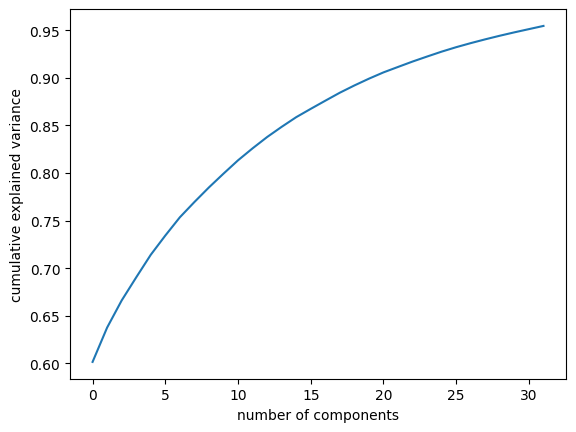

In [48]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [49]:
pca_df = pd.concat([princ_df, nodes[['semantic']]], axis=1)
pca_df

,principal component 1,principal component 2,semantic
0,-0.501037,0.104968,gene
1,-0.675635,1.858255,phenotype
2,-0.705207,-0.219281,phenotype
3,-0.783578,-1.642219,phenotype
4,-0.564439,-0.885569,gene
...,...,...,...
14877,-0.722144,-0.470823,phenotype
14878,-0.572844,-0.254178,gene
14879,0.739002,1.568477,phenotype
14880,-0.562419,-1.634958,phenotype


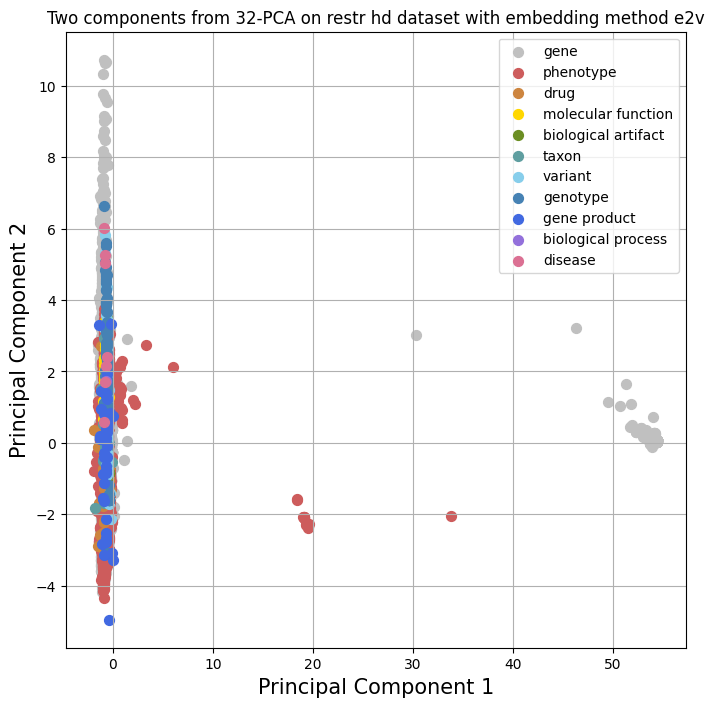

In [50]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(f'Two components from 32-PCA on {dataset_prefix} {disease_prefix} dataset with embedding method {embedding_method}', fontsize = 12)

unique_node_semantics = list(node_semantic_dict.values())
colors = ['silver', 'indianred', 'peru', 'gold', 'olivedrab', 'cadetblue', 'skyblue', 'steelblue', 'royalblue', 'mediumpurple', 'palevioletred', 'lightpink']

for target, color in zip(unique_node_semantics, colors):
    indicesToKeep = pca_df['semantic'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1'], pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
    
ax.legend(unique_node_semantics)
ax.grid()

plt.show()

### t-SNE

In [51]:
X_tsne = TSNE(learning_rate=100, perplexity=40).fit_transform(X_data)

In [52]:
comp_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE 1', 't-SNE 2'])
comp_tsne

,t-SNE 1,t-SNE 2
0,-49.783455,-1.340077
1,19.247110,37.366364
2,23.579403,-18.132181
3,-39.803425,-3.500276
4,-40.667095,24.352711
...,...,...
14877,21.406040,7.393819
14878,-48.774818,11.599901
14879,14.006907,33.268784
14880,39.901714,-47.019077


In [53]:
tsne_df = pd.concat([comp_tsne, nodes[['semantic']]], axis=1)
tsne_df

,t-SNE 1,t-SNE 2,semantic
0,-49.783455,-1.340077,gene
1,19.247110,37.366364,phenotype
2,23.579403,-18.132181,phenotype
3,-39.803425,-3.500276,phenotype
4,-40.667095,24.352711,gene
...,...,...,...
14877,21.406040,7.393819,phenotype
14878,-48.774818,11.599901,gene
14879,14.006907,33.268784,phenotype
14880,39.901714,-47.019077,phenotype


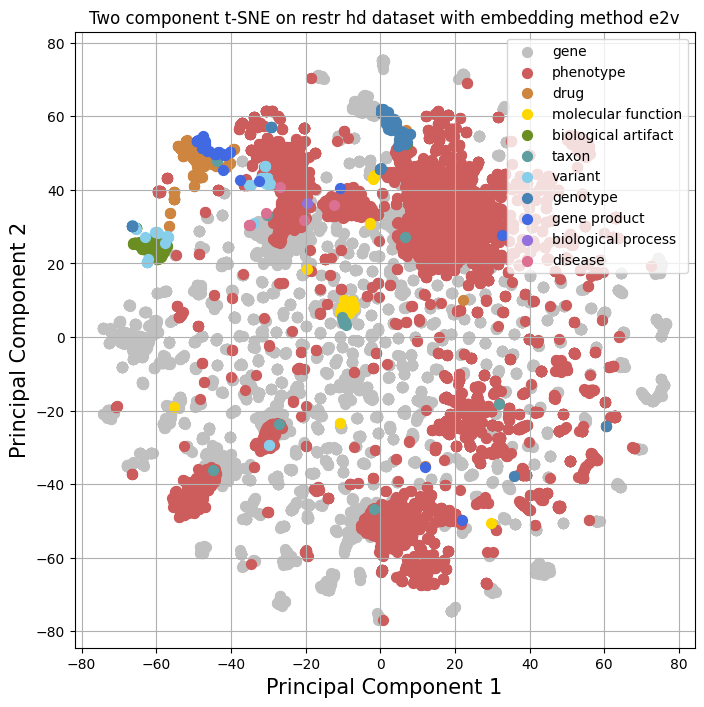

In [54]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(f'Two component t-SNE on {dataset_prefix} {disease_prefix} dataset with embedding method {embedding_method}', fontsize = 12)

unique_node_semantics = list(node_semantic_dict.values())
colors = ['silver', 'indianred', 'peru', 'gold', 'olivedrab', 'cadetblue', 'skyblue', 'steelblue', 'royalblue', 'mediumpurple', 'palevioletred', 'lightpink']

for target, color in zip(unique_node_semantics, colors):
    indicesToKeep = tsne_df['semantic'] == target
    ax.scatter(tsne_df.loc[indicesToKeep, 't-SNE 1'], tsne_df.loc[indicesToKeep, 't-SNE 2'], c = color, s = 50)
    
ax.legend(unique_node_semantics)
ax.grid()

plt.show()